## Load Training Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

%matplotlib inline

# make plots look betters
plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = (8,6)
# plt.rcParams['figure.dpi'] = (300)
plt.rcParams['font.size'] = 12

comments = pd.read_pickle('../toxic_comment_data/combined_train_data.csv')

## Feature Extraction

Previously, we only did feature extraction on the Comments column of the data frame, so we could just pass that directly to fit(). Now however, we would like to pass the whole data frame so we can extract particular features from it. Thus, we first we have to write some code to extract the information we want. The canonical way of doing this is with transformer extractor methods that can be used as part of a pipeline.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

# allows us to select a column by name from a data frame and return it as a nparray of type string
class TextExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def transform(self, data):
        return np.asarray(data[self.column]).astype(str)
    
    # not used
    def fit(self, *_):
        return self 

# allows us to select a column by name from a data frame and return it as a nparray of the specified type
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column, dtype):
        self.dtype = dtype
        self.column = column

    def transform(self, data):
        data = np.asarray(data[self.column]).astype(self.dtype)
         
        # note: reshaping is necessary because otherwise sklearn
        # interprets 1-d array as a single sample
        # reshapes from row vector to column vector
        data = data.reshape(data.size, 1) 
        return data
    
    # not used
    def fit(self, *_):
        return self

In [4]:
# these pipelines can be a mess so I tried to break it into manageable chunks

# a separate pipeline can be created for each feature we extract
# for one liners this isnt done, and instead the extractors are called in the feature union

char_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='char')),
    ('tfidf', TfidfTransformer())
])

word_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='word')),
    ('tfidf', TfidfTransformer())
])

# the features combined
features = FeatureUnion([
    ('char_ngrams', char_ngram_features),
    ('word_ngrams', word_ngram_features),
    ('norm_length', ColumnExtractor('Norm_True_Length',float)),
    ('weekday', ColumnExtractor('Weekday',int)),
    ('day', ColumnExtractor('Day',int)),
    ('month', ColumnExtractor('Month',int)),
    ('year', ColumnExtractor('Year',int)),
    ('hour', ColumnExtractor('Hour',int)),
    ('minute', ColumnExtractor('Minute',int)),
    ('second', ColumnExtractor('Second',int))
])

# set the classifier
#--** this is where to change the classifier **--
# The parameters are default values, if they are not given here we end up with ugly warnings later on
classifier = SGDClassifier(max_iter=5, tol=None)

# set the feature selection (these params can also be grid searched)
select = SelectPercentile(score_func=chi2, percentile=25)

pipeline = Pipeline([
    ('union', features),
    ('select', select),
    ('classifier', classifier)
])

In [4]:
pipeline.fit(comments, comments.Insult);

In [5]:
parameters = {'union__char_ngrams__vectorizer__ngram_range': [(1, 1), (1, 2)] # the range of the n-grams
             }

# the names are important, e.g. vect__ corresponds to the name given to the class in the pipeline,
# while "ngram_range" is a parameter for the class, i.e. CountVectorizer

gs_clf = GridSearchCV(pipeline, parameters, n_jobs=-1) # run the grid search on the chosen pipeline
gs_clf = gs_clf.fit(comments, comments.Insult) 

In [6]:
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.6819880418535127
{'union__char_ngrams__vectorizer__ngram_range': (1, 1)}


## Grid Search Example

Continuing from above, we already fit a NB classifier, and saw its accuracy. We now plot the ROC curve:

Plot ROC:

In [3]:
# make a function for plotting the roc
def plot_roc(train_labels, predicted_labels):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_labels,predicted_labels)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate');

Pretty awful. Now try doing some grid search:

In [8]:
from timeit import default_timer as timer

start = timer() # start timer so we can see how long it takes

# IF YOU RUN THIS AS IS IT WILL TAKE AN HOUR OR TWO TO FINISH
parameters_ngrams = {
                'union__char_ngrams__vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)], # the range of the n-grams
                'union__char_ngrams__vectorizer__stop_words': [None, 'english'], # remove stopwords or not
                'union__char_ngrams__tfidf__use_idf': (True, False), # use idf or not
                'union__word_ngrams__vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],
                'union__word_ngrams__vectorizer__stop_words': [None, 'english'],
                'union__word_ngrams__tfidf__use_idf': (True, False)
             }

parameters_classifier = {
                'classifier__alpha' : [0.01, 0.001, 0.0001], # change alpha hyperparameter
                'classifier__loss' : ['hinge', 'modified_huber', 'log'],
                'classifier__penalty' : ['l2', 'l1', 'elasticnet'],
                'classifier__max_iter': [1000, 2000, 4000],
                'classifier__tol' : [None, 1e-3],
                'select__percentile' : [10,20,40] # percentage of best features to select
            }



# The names here are very important. the intuition is that they follow from the pipeline hierarchy.
# For example, to access the ngram_range parameter for CountVectorizer, you have to follow the hierarchy
# starting at the feature union, and use the corresponding names with two '__' between each.

# So the format is: name__name__(...)__parameter
# The last name on the string e.g. "ngram_range" is a parameter for the class, in this case, CountVectorizer

gs_clf_1 = GridSearchCV(pipeline, parameters_ngrams, n_jobs=-1) # run the grid search on the chosen pipeline
gs_clf_2 = GridSearchCV(pipeline, parameters_classifier, n_jobs=-1)
gs_clf_1 = gs_clf_1.fit(comments, comments.Insult)
gs_clf_2 = gs_clf_2.fit(comments, comments.Insult) 


end = timer()
print(end - start)

3142.024595597002


In [9]:
print("Training time:", round((end-start)/60/60,2), "hours")

Training time: 0.87 hours


Print out the best score found, and the parameters that go with it:

In [10]:
print(gs_clf_1.best_score_)
print(gs_clf_2.best_score_)
print(gs_clf_1.best_params_)
print(gs_clf_2.best_params_)

0.7088938714499252
0.8292227204783259
{'union__char_ngrams__tfidf__use_idf': False, 'union__char_ngrams__vectorizer__ngram_range': (1, 1), 'union__char_ngrams__vectorizer__stop_words': None, 'union__word_ngrams__tfidf__use_idf': False, 'union__word_ngrams__vectorizer__ngram_range': (1, 3), 'union__word_ngrams__vectorizer__stop_words': None}
{'classifier__alpha': 0.0001, 'classifier__loss': 'hinge', 'classifier__max_iter': 4000, 'classifier__penalty': 'elasticnet', 'classifier__tol': None, 'select__percentile': 20}


See how the new classifier does on accuracy: (noticeable improvement)

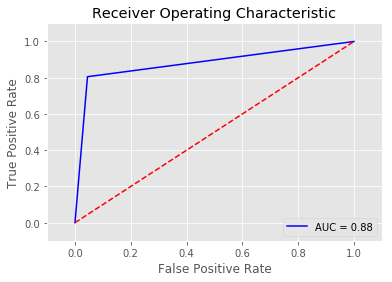

In [30]:
# Hardcoded the best features chosen above because I couldn't find a way to combine the two results otherwise.

char_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='char', stop_words=None, ngram_range = (1, 1))),
    ('tfidf', TfidfTransformer(use_idf=False))
])

word_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='word', stop_words=None, ngram_range = (1, 3))),
    ('tfidf', TfidfTransformer(use_idf=False))
])

# the features combined
features = FeatureUnion([
    ('char_ngrams', char_ngram_features),
    ('word_ngrams', word_ngram_features),
    ('norm_length', ColumnExtractor('Norm_True_Length',float)),
    ('weekday', ColumnExtractor('Weekday',int)),
    ('day', ColumnExtractor('Day',int)),
    ('month', ColumnExtractor('Month',int)),
    ('year', ColumnExtractor('Year',int)),
    ('hour', ColumnExtractor('Hour',int)),
    ('minute', ColumnExtractor('Minute',int)),
    ('second', ColumnExtractor('Second',int))
])

select = SelectPercentile(score_func=chi2, percentile=20)

classifier = SGDClassifier(max_iter=4000, tol=None, penalty='elasticnet', loss='hinge', alpha=0.0001)
pipeline = Pipeline([
    ('union', features),
    ('select', select),
    ('classifier', classifier)
])

pipeline.fit(comments, comments.Insult)

predicted = pipeline.predict(comments)
plot_roc(comments.Insult, predicted)

Model took a while to train, so we may wish to save for future use:

In [31]:
from sklearn.externals import joblib
joblib.dump(pipeline, 'SGDClassifier.pkl');

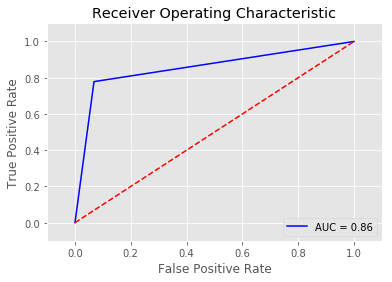

In [4]:
# Alex suggested using specific ngram parameter values, so making a new model with those

char_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='char', stop_words=None, ngram_range = (1, 3))),
    ('tfidf', TfidfTransformer(use_idf=True))
])

word_ngram_features = Pipeline([
    ('extractor', TextExtractor('Comment')),
    ('vectorizer', CountVectorizer(analyzer='word', stop_words=None, ngram_range = (1, 2))),
    ('tfidf', TfidfTransformer(use_idf=False))
])

# the features combined
features = FeatureUnion([
    ('char_ngrams', char_ngram_features),
    ('word_ngrams', word_ngram_features),
    ('norm_length', ColumnExtractor('Norm_True_Length',float)),
    ('weekday', ColumnExtractor('Weekday',int)),
    ('day', ColumnExtractor('Day',int)),
    ('month', ColumnExtractor('Month',int)),
    ('year', ColumnExtractor('Year',int)),
    ('hour', ColumnExtractor('Hour',int)),
    ('minute', ColumnExtractor('Minute',int)),
    ('second', ColumnExtractor('Second',int))
])

select = SelectPercentile(score_func=chi2, percentile=10)

classifier = SGDClassifier()
pipeline = Pipeline([
    ('union', features),
    ('select', select),
    ('classifier', classifier)
])

parameters_classifier = {
                'classifier__alpha' : [0.01, 0.001, 0.0001], # change alpha hyperparameter
                'classifier__loss' : ['hinge', 'modified_huber', 'log'],
                'classifier__penalty' : ['l2', 'l1', 'elasticnet'],
                'classifier__max_iter': [1000, 2000, 4000],
                'classifier__tol' : [None, 1e-3]
            }

gs_final = GridSearchCV(pipeline, parameters_classifier, n_jobs=-1)


gs_final.fit(comments, comments.Insult)

predicted = gs_final.predict(comments)
plot_roc(comments.Insult, predicted)

In [ ]:
from sklearn.externals import joblib

print(gs_clf_2.best_score_)
print(gs_clf_1.best_params_)

joblib.dump(pipeline, 'SGDClassifier_Alex_feature_params.pkl');